[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1dCI_nSML0JY9WiLvA28fvGyVI_3Z16yW)


## ResNet
- Reference: https://github.com/raghakot/keras-resnet
- No Dense layers
- GlobalAveragePooling for last layer

In [0]:
from keras.preprocessing import image
import tensorflow.keras.backend as K
import cv2
import sys
import numpy as np

In [1]:
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Flatten
)
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.layers import Activation

def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        pointwise = Conv2D(num_outputs, (1, 1), use_bias=False)(block)
        gap = GlobalAveragePooling2D()(pointwise)
        softmax = Activation('softmax')(gap)
        
        model = Model(inputs=input, outputs=softmax)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

Using TensorFlow backend.


## Training ResNet18 on CIFAR-10
- 84.07% Validation accuracy


In [2]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import numpy as np


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

filepath="weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, lr_reducer, early_stopper]

nb_classes = 10
# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0712 17:08:41.952620 139794215344000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 17:08:42.861540 139794215344000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 17:08:42.872410 139794215344000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0712 17:08:42.920470 139794215344000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 17:08:42.921398

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
)

# calculate mean and standard deviation on training dataset
datagen.fit(X_train)

# prepare an iterators to scale images
train_iterator = datagen.flow(X_train, Y_train, batch_size=256)
val_iterator = datagen.flow(X_test, Y_test, batch_size=256)

In [5]:
model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=50, verbose=1, validation_data=val_iterator, validation_steps=len(val_iterator), callbacks=callbacks_list)

W0712 17:08:48.504034 139794215344000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
196/196 [==============================] - 37s 187ms/step - loss: 1.9912 - acc: 0.4978 - val_loss: 1.8974 - val_acc: 0.5238

Epoch 00001: val_acc improved from -inf to 0.52380, saving model to weights.01-0.5238.hdf5
Epoch 2/50
196/196 [==============================] - 24s 125ms/step - loss: 1.5347 - acc: 0.6247 - val_loss: 1.5089 - val_acc: 0.6236

Epoch 00002: val_acc improved from 0.52380 to 0.62360, saving model to weights.02-0.6236.hdf5
Epoch 3/50
196/196 [==============================] - 25s 130ms/step - loss: 1.3415 - acc: 0.6752 - val_loss: 1.4269 - val_acc: 0.6293

Epoch 00003: val_acc improved from 0.62360 to 0.62930, saving model to weights.03-0.6293.hdf5
Epoch 4/50
196/196 [==============================] - 25s 129ms/step - loss: 1.2233 - acc: 0.7026 - val_loss: 1.2854 - val_acc: 0.6812

Epoch 00004: val_acc improved from 0.62930 to 0.68120, saving model to weights.04-0.6812.hdf5
Epoch 5/50
196/196 [==============================] - 25s 129ms/step - loss: 1.1331

## Save Model

In [38]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
model.save('model_resnet18_cifar10.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


## Load Model

In [1]:
from google.colab import drive
from keras.models import load_model
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
model = load_model('model_resnet18_cifar10.h5')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


W0712 17:01:37.047828 140715531708288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 17:01:37.156910 140715531708288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0712 17:01:37.209043 140715531708288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 17:01:37.210349 140715531708288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 17:01:37.21530

In [0]:
import tensorflow as tf
K.get_session().run(tf.initialize_all_variables())

## Predictions on Validation Set

In [0]:
Y_pred = model.predict_generator(val_iterator, steps=len(val_iterator))

In [7]:
print(Y_pred[:9])
print(Y_test[:9])

[[5.35493391e-03 7.10351527e-01 1.31146408e-05 7.54381472e-04
  1.29040249e-03 3.14570279e-05 1.57662388e-03 4.07650219e-07
  2.78537869e-01 2.08937074e-03]
 [1.77722834e-02 4.08118212e-04 1.29148772e-03 3.12481352e-05
  1.80931750e-03 6.13880620e-05 8.12162273e-03 4.29107195e-06
  9.70456421e-01 4.38015850e-05]
 [9.96128678e-01 8.37970765e-06 1.64818455e-04 2.77805583e-07
  9.64109495e-06 1.33229165e-07 1.01432761e-07 5.87496174e-07
  3.68524389e-03 2.07887365e-06]
 [2.32908987e-02 1.71843116e-04 2.39963606e-02 5.54385083e-03
  9.44547534e-01 1.40079152e-04 4.09376335e-05 1.27610576e-04
  3.79767152e-04 1.76103145e-03]
 [1.02046045e-07 7.97127910e-08 1.97950303e-05 9.57235813e-01
  3.69729416e-04 4.16730009e-02 6.71653484e-04 2.91668784e-05
  1.78411668e-08 6.95713425e-07]
 [1.51686286e-09 9.48354283e-14 1.00000000e+00 3.04901104e-10
  6.25198331e-12 2.06501569e-11 1.49999596e-11 9.20294917e-12
  9.80544292e-12 1.77691076e-12]
 [3.82566614e-05 8.71317388e-06 3.35712843e-02 8.26249480e

## GradCam on 50 Misclassified Images from the Validation Set

W0712 18:38:39.012381 139794215344000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0712 18:38:47.932555 139794215344000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
W0712 18:38:56.830685 139794215344000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0712 18:39:05.732260 139794215344000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0712 18:39:14.699398 139794215344000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0712 18:39:23.699782 139794215344000 image.py:648] Clipping input d

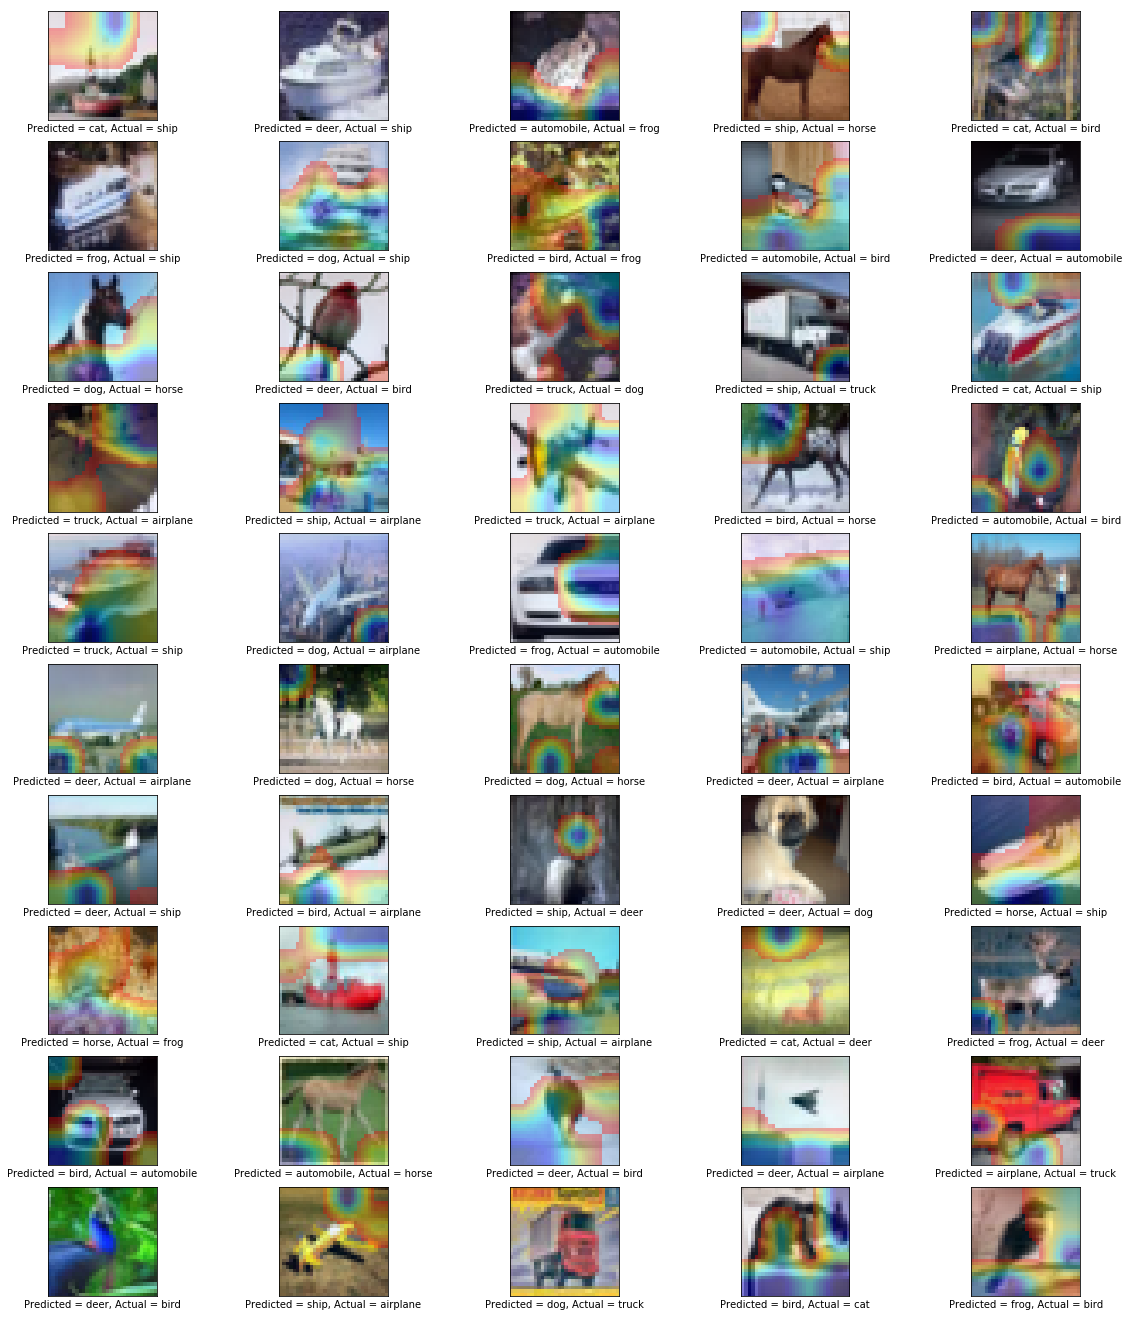

In [35]:
import matplotlib.pyplot as plt

classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

y_true = np.argmax(Y_test, axis=1)
yp = np.argmax(Y_pred, axis=1)
misclassified = y_true != yp
X_test = X_test[misclassified]
Y_test = Y_test[misclassified]
Y_pred = Y_pred[misclassified]
y_true = y_true[misclassified]
yp = yp[misclassified]

indexes = np.random.choice(len(X_test), 50, replace=False)

X_test = np.take(X_test, indexes, axis=0)
Y_test = np.take(Y_test, indexes, axis=0)
Y_pred = np.take(Y_pred, indexes, axis=0)
y_true = np.take(y_true, indexes, axis=0)
yp = np.take(yp, indexes, axis=0)

fig_height = 5 * 8
fig_width = 5 * 4

fig = plt.figure(figsize=(fig_width, fig_height))
plt.subplots_adjust(bottom=0.1, top=1.0)
idx1 = 0
jdx = 0
for row in range(10):
    for column in range(5):
        if idx1 >= len(X_test):
            break
        img = X_test[idx1]
        assert (len(img.shape) == 3 and img.shape[2] in [1, 3, 4]) or len(img.shape) == 2
        ax = fig.add_subplot(5 * 2 * 2, 5, jdx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape) == 3 and img.shape[2] == 1) or len(img.shape) == 2:
            cmap = "binary"
        if len(img.shape) == 3 and img.shape[2] == 1:
            img = img.reshape((img.shape[0], img.shape[1]))
        ax.imshow(img, cmap=cmap)
        ax.set_xlabel("Predicted = %s, Actual = %s" % (classes[yp[idx1]], classes[y_true[idx1]]))
    
        class_output = model.output[:, yp[idx1]]
        last_conv_layer = model.get_layer("conv2d_10")
        layer_out_channels = last_conv_layer.output_shape[-1]

        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        x = np.expand_dims(image.img_to_array(img), axis=0)
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([x])
        for i in range(layer_out_channels):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


        heatmap = heatmap/255
        for i in range(len(heatmap)):
          for j in range(len(heatmap[0])):
            if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
              heatmap[i][j] = 0

        img = (img - np.min(img))/(np.max(img)-np.min(img))
        superimposed_img = 0.65*(img) + 0.35*heatmap

        for i in range(len(heatmap)):
          for j in range(len(heatmap[0])):
            if np.sum(heatmap[i][j])==0:
              superimposed_img[i][j]=img[i][j]
        
        ax.imshow(superimposed_img, cmap=cmap)
        ax.set_xlabel("Predicted = %s, Actual = %s" % (classes[yp[idx1]], classes[y_true[idx1]]))
              
        idx1 += 1
        jdx += 1
          
plt.show()